# 株式会社ALBERT 2019年度夏季インターン選抜課題
## 回答条件・提出物について
### 条件
- 回答には python 3.6 以上を用いること．
- 使用ライブラリに制限は設けない．
- 回答期限は１週間です．全問解けている必要はありません．可能な範囲で回答し提出してください．

### 提出物
- 回答を記述した本ノートブック．


## 問題
強化学習とは、 **エージェント (agent)** の行動決定問題を扱う機械学習分野の一領域である。  
エージェントは周囲の環境の **状態 (state)** を観測し **行動 (action)** を選択する。  
その際、環境から得られる **報酬 (reward)** を最大化するように行動指針を更新することで、適切な行動戦略を学習する。

本課題では強化学習の一種である **Q 学習** を扱う。  
Q 学習ではエージェントに **Q 値** という値を持たせ、これを各行動の有効性を示したものと考える。  
エージェントは環境の中で行動を繰り返し、得られた報酬をもとに Q 値を調整してゆくことで、だんだんと賢くなっていくのである。

さて、以下にあるのは **○×ゲーム (Tic-tac-toe)** のプログラムコードである。○×ゲームのルールは次の通りである。
1. 3x3 のマス目を用意する
1. 先手・後手がそれぞれ交互に○と×をマス目に書き込んでいく
1. 縦横斜めいずれか一列を先に自分のマークで埋めた方が勝ち

今回の実装では、これを次のように実現している。
1. TicTacToe クラスは、Player クラスを内部に持つ
1. TicTacToe クラスは、先手後手交互に Player クラスの action メソッドを呼ぶ
1. action メソッドの戻り値をうけて TicTacToe クラスはゲームを進め、勝敗が決すれば Player クラスの finalize メソッドを呼ぶ

TicTacToe クラスは action に際し、盤面情報 (board) を Player に渡すが、その盤面情報は渡す相手に合わせて normalize されていることに注意されたい。  
すなわち、渡す相手のマークを MY_MARK, 渡す相手の敵のマークを ENEMY_MARK に変換してから board 配列を渡している。

本課題の目的は、この○×ゲームを Q 学習によって攻略することである。  
問題文に従ってプログラムを実装し、○×ゲームをプレイするエージェントを実装しなさい。

In [1]:
import copy

from tqdm import tqdm
import numpy as np
import pylab as plt

### 定数

In [2]:
WIN = 1
DRAW = 0
LOSE = -1

EMPTY = 0
MY_MARK = 1
ENEMY_MARK = -1

### ゲーム盤クラス

In [3]:
class TicTacToe(object):

    NUM_EMPTY = 0
    NUM_X = 1
    NUM_O = -1

    def __init__(self, X, O):
        self.X = X
        self.O = O
        self.board = np.full(9, self.NUM_EMPTY, dtype=np.int32)
        self.num2player = {self.NUM_X: self.X,
                           self.NUM_O: self.O}
        self.num2mark = {self.NUM_EMPTY: ' ',
                         self.NUM_X: 'X',
                         self.NUM_O: 'O'}

    def opposite_turn(self, turn):
        if turn == self.NUM_X:
            return self.NUM_O
        else:
            return self.NUM_X

    def normalized_board(self, turn):
        board = np.full(9, EMPTY, dtype=np.int32)
        board[self.board == turn] = MY_MARK
        board[self.board == self.opposite_turn(turn)] = ENEMY_MARK
        return board

    def move_and_judge(self, pos, turn):
        winner = None
        loser = None
        game_is_over = False

        winning_conditions = tuple([
            [[0, 1, 2], [3, 4, 5], [6, 7, 8],
             [0, 3, 6], [1, 4, 7], [2, 5, 8],
             [0, 4, 8], [2, 4, 6]]
        ])

        if self.board[pos] != self.NUM_EMPTY:
            game_is_over = True
            winner = self.opposite_turn(turn)
            loser = turn
            return game_is_over, winner, loser

        # update board.
        self.board[pos] = turn

        if not (self.board == self.NUM_EMPTY).any():
            game_is_over = True

        if (self.board[winning_conditions] == turn).all(axis=1).any():
            winner = turn
            loser = self.opposite_turn(turn)
            game_is_over = True

        return game_is_over, winner, loser

    def print_board(self):
        marks = [self.num2mark[num] for num in self.board]
        board_text = (
            ' {} | {} | {} \n-----------\n'
            ' {} | {} | {} \n-----------\n'
            ' {} | {} | {}'.format(*marks))
        print(board_text + '\n')

    def print_actions(self):
        board_text = (
            ' {} | {} | {} \n-----------\n'
            ' {} | {} | {} \n-----------\n'
            ' {} | {} | {}'.format(*np.arange(9)))
        print('actions: \n' + board_text + '\n')

    def main_loop(self, print_game=False):
        turn = self.NUM_X
        game_is_over = False

        if print_game:
            self.print_actions()

        while not game_is_over:
            if print_game:
                print('{}({})\'s turn.'.format(
                    self.num2player[turn].name, self.num2mark[turn]))
                self.print_board()

            player = self.num2player[turn]

            normalized_board = self.normalized_board(turn)
            pos = player.action(normalized_board)
            game_is_over, winner, loser = self.move_and_judge(pos, turn)

            turn = self.opposite_turn(turn)

        if print_game:
            self.print_board()
            print('GAME is OVER!')
            if winner is None:
                print('DRAW')
            else:
                print('WINNER: {}'.format(self.num2player[winner].name))

        if winner is None:  # DRAW
            self.X.finalize(DRAW, self.normalized_board(self.NUM_X))
            self.O.finalize(DRAW, self.normalized_board(self.NUM_O))
        else:
            self.num2player[winner].finalize(
                WIN, self.normalized_board(winner))
            self.num2player[loser].finalize(
                LOSE, self.normalized_board(loser))


### Player（人間）クラス

In [4]:
class HumanPlayer(object):

    def __init__(self, name):
        self.name = name

    def action(self, board):
        a = int(input())
        return a

    def finalize(self, condition, board):
        pass


In [7]:
# 実行例
human1 = HumanPlayer('YAMAUCHI')
human2 = HumanPlayer('KATAGIRI')

game = TicTacToe(human1, human2)
game.main_loop(print_game=True)

actions: 
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8

YAMAUCHI(X)'s turn.
   |   |   
-----------
   |   |   
-----------
   |   |  



 0


KATAGIRI(O)'s turn.
 X |   |   
-----------
   |   |   
-----------
   |   |  



 0


 X |   |   
-----------
   |   |   
-----------
   |   |  

GAME is OVER!
WINNER: YAMAUCHI


### 問１
board を受け取って、可能なマス目をランダムに選んで行動する RandomPlayer クラスをつくりたい。  
以下の RandomPlayer クラスの action メソッドを完成させ、RandomPlayer 同士の対局を実行しなさい。

### Player（ランダム）クラス

In [8]:
class RandomPlayer(object):

    def __init__(self, name):
        self.name = name

    def action(self, board):
        a_candidate = np.arange(9)[board == EMPTY]
        return np.random.choice(a_candidate)

    def finalize(self, condition, board):
        pass


In [9]:
random1 = RandomPlayer('乱太郎')
random2 = RandomPlayer('乱次郎')

game = TicTacToe(random1, random2)
game.main_loop(print_game=True)

actions: 
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8

乱太郎(X)'s turn.
   |   |   
-----------
   |   |   
-----------
   |   |  

乱次郎(O)'s turn.
   |   | X 
-----------
   |   |   
-----------
   |   |  

乱太郎(X)'s turn.
   |   | X 
-----------
 O |   |   
-----------
   |   |  

乱次郎(O)'s turn.
   |   | X 
-----------
 O |   |   
-----------
 X |   |  

乱太郎(X)'s turn.
   |   | X 
-----------
 O |   |   
-----------
 X | O |  

乱次郎(O)'s turn.
 X |   | X 
-----------
 O |   |   
-----------
 X | O |  

乱太郎(X)'s turn.
 X |   | X 
-----------
 O | O |   
-----------
 X | O |  

乱次郎(O)'s turn.
 X |   | X 
-----------
 O | O | X 
-----------
 X | O |  

乱太郎(X)'s turn.
 X |   | X 
-----------
 O | O | X 
-----------
 X | O | O

 X | X | X 
-----------
 O | O | X 
-----------
 X | O | O

GAME is OVER!
WINNER: 乱太郎


Q 学習では、Q 値を用いて行動決定を行う。  
Q 値はすべての (状態 $s$, 行動 $a$) の組に対して定義され、状態 $s$ において行動 $a$ を選択する有効性を示す。  
ここで、状態 $s$ における 行動 $a$ の Q 値を $ Q(s, a) $ と書くことにする。

Q 学習ではエージェントは状態 $s$ を観測し、Q 値を最大化する行動 $a$ を選択する。すなわち、状態 $s$ における行動 $ a(s) $ は、
$$
a(s) = argmax_a Q(s, a)
$$
で表される。  

Q 値の更新は次のように行われる。
$$
Q^{new}(s, a) = Q(s, a) + lr \cdot (r + \gamma \cdot max_a Q(s', a) - Q(s, a))
$$
ただし、 $lr$ は **学習率**、$\gamma$ は **割引率**、 $r$ は 状態 $s$ において行動 $a$ を取った直後に得られた **報酬**、 $s'$ は 状態 $s$ において行動 $a$ を取った直後に観測された状況である。  

更新式から明らかなように、状態 $s$ で行動 $a$ を取った際に正の $r$ が得られたとすると $Q(s, a)$ の値は大きくなる。  
したがって、良い行動を取ったときに大きな $r$ を与え、間違ったときに小さな $r$ を与えるようしてやれば、エージェントの行動は改善されていくと考えられる。  
どのような報酬 $r$ を与えるか（報酬設計）は強化学習一般において重要な問題である。

さて、○×ゲームのような環境では、勝敗が決するまで、途中の各行動が良かったのかどうか判定できない。  
そのため、勝敗に通じる最後の行動以外については適切な報酬を与えることが難しい。  
Q 学習では状態 $s'$ における Q 値の（$a$ をいろいろ動かしたときの）最大値を更新時に加えることで、この問題に対処している。  
次の時点での Q 値（の最大値）を現在の Q 値に伝播させることで、最後にのみ与えられる報酬の影響を、それ以前に遡って分配することができるのである。  
（割引率 $\gamma$ は、未来の報酬にどの程度影響を受けるかを制御するハイパーパラメタである。）

ところで、上記のように Q 値を更新すると、エージェントは特定の行動ばかりを取るようになってしまうことが考えられる。  
そうなるとエージェントは新しい局面に触れることがなくなり、学習が進まなくなってしまう場合がある。  
それを防ぐ方法として、確率 $\epsilon$ でランダムな行動を取る ε-greedy 法などのアルゴリズムが知られている。  
ランダムに環境を探索させることで、エージェントにより詳しく環境について学んでもらおうという企みである。

以下の実装では、Q 値を QTable クラスとして実装している。  
QTable クラスは、状態 $s$ を Key，各行動 $a$ に対する Q 値（の配列）を Value とする辞書を内部に持ち、getitem メソッド、setitem メソッドによって Q 値を取り出したり書き換えたりできるようになっている。

また、Q 値を更新するには、$s$, $a$, $s'$, $r$ を保存しておく必要があるので、これらを記憶する Memory クラスを用意した。  
Memory クラスは $s$, $a$, $s'$, $r$ 及び、エピソード終了を表すフラグ $e$ を保存する。
 
QLearningPlayer クラスは QTable, Memory をもち、Q 値に従った行動決定と、局面の保存を行う。

### 問2
QLearningPlayer クラスの action メソッドを完成させなさい。  
また、Q 値を更新する train_q_table 関数を完成させ、エージェントを訓練しなさい。

### QTable クラス

In [10]:
class QTable(object):

    def __init__(self):
        self.table = {}

    @staticmethod
    def s2key(s):
        return np.str(s)

    def getitem(self, s, a=None):
        key = self.s2key(s)

        if key not in self.table:
            self.table[key] = np.zeros(9, dtype=np.float32)

        if a is None:
            return self.table[key]
        else:
            return self.table[key][a]

    def setitem(self, s, a, value):
        key = self.s2key(s)

        if key not in self.table:
            self.table[key] = np.zeros(9, dtype=np.float32)

        self.table[key][a] = value


### Memory クラス

In [11]:
class Memory(object):

    def __init__(self, size=10):
        self.size = size
        self.memory = np.empty((size, 21), dtype=np.float32)
        self.counter = 0

    def __len__(self):
        return min(self.size, self.counter)

    def read(self, ind):
        s = self.memory[ind, :9].astype(np.int32)
        a = self.memory[ind, 9].astype(np.int32)
        s_dash = self.memory[ind, 10:19].astype(np.int32)
        r = self.memory[ind, 19]
        e = self.memory[ind, 20]
        return s, a, s_dash, r, e

    def write(self, ind, s, a, s_dash, r, e):
        self.memory[ind, :9] = s
        self.memory[ind, 9] = a
        self.memory[ind, 10:19] = s_dash
        self.memory[ind, 19] = r
        self.memory[ind, 20] = e

    def append(self, s, a, s_dash, r, e):
        ind = self.counter % self.size
        self.write(ind, s, a, s_dash, r, e)
        self.counter += 1


### Player（Q 学習）クラス

In [12]:
class QLearningPlayer(object):

    def __init__(self, name, q_table, memory,
                 reward_win=1., reward_draw=0., reward_lose=-1.,
                 eps=0.05):
        self.name = name
        self.reward_win = reward_win
        self.reward_draw = reward_draw
        self.reward_lose = reward_lose
        self.eps = eps

        self.q_table = q_table
        self.memory = memory

        self.s_last = None
        self.a_last = None

        self.record = []

    def action(self, board):
        s = board

        # decide the action
        if np.random.random() < self.eps:
            # epsilon-greedy. ランダムな行動
            a_candidate = np.arange(9)[board == EMPTY]
            a = np.random.choice(a_candidate)
        else:
            # Q 値に従った行動
            q = self.q_table.getitem(s)
            q[board != EMPTY] = -np.inf
            a = np.argmax(q)

        # memorise state and action
        if self.s_last is not None:
            self.memory.append(self.s_last, self.a_last, s, 0, 0)
        self.s_last = board
        self.a_last = a

        return a

    def finalize(self, condition, board):
        s = board
        if condition == WIN:
            r = self.reward_win
        elif condition == DRAW:
            r = self.reward_draw
        else:
            r = self.reward_lose
        self.memory.append(self.s_last, self.a_last, s, r, 1)

        self.s_last = None
        self.a_last = None

        self.record.append(condition)


In [13]:
def train_q_table(q_table, memory, lr=0.1, gamma=0.95, n_epoch=1):
    q_table_copy = copy.deepcopy(q_table)

    for e in range(n_epoch):
        for i in range(len(memory)):
            s, a, s_dash, r, e = memory.read(i)
            q_s_a = q_table.getitem(s, a)
            if e == 0:
                max_q_s_a_dash = np.max(q_table_copy.getitem(s_dash))
            else:
                max_q_s_a_dash = 0

            # Q 値の更新
            q_s_a_new = q_s_a + lr * (r + gamma * max_q_s_a_dash - q_s_a)
            q_table.setitem(s, a, q_s_a_new)

### 学習

In [14]:
random = RandomPlayer('乱太郎')

In [15]:
q_table = QTable()
memory = Memory()

q_learning = QLearningPlayer('Q太郎', q_table, memory, eps=0.05)

In [16]:
for i in tqdm(range(10000)):

#     if i % 100 == 0:
#         print(i, end=', ')

    if np.random.random() > 0.5:
        X = random
        O = q_learning
    else:
        X = q_learning
        O = random

    game = TicTacToe(X, O)
    game.main_loop(print_game=False)
    train_q_table(q_table, memory)

100%|██████████| 10000/10000 [00:34<00:00, 289.93it/s]


In [17]:
game = TicTacToe(q_learning, random)
game.main_loop(print_game=True)

actions: 
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8

Q太郎(X)'s turn.
   |   |   
-----------
   |   |   
-----------
   |   |  

乱太郎(O)'s turn.
 X |   |   
-----------
   |   |   
-----------
   |   |  

Q太郎(X)'s turn.
 X |   |   
-----------
   |   |   
-----------
 O |   |  

乱太郎(O)'s turn.
 X | X |   
-----------
   |   |   
-----------
 O |   |  

Q太郎(X)'s turn.
 X | X |   
-----------
 O |   |   
-----------
 O |   |  

 X | X | X 
-----------
 O |   |   
-----------
 O |   |  

GAME is OVER!
WINNER: Q太郎


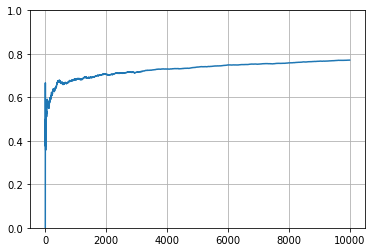

In [18]:
# 勝率の変化
wininig_Q = np.array(q_learning.record) == WIN

plt.grid(True)
plt.ylim(0, 1)
plt.plot(np.cumsum(wininig_Q) / (np.arange(len(wininig_Q)) + 1))

問２では、Q 値を状態 $s$ を Key とする辞書で表現していた。  
○×ゲームのように状態数に限りがある環境ではこれでも問題ないが、例えば TV ゲームのような複雑な環境では、状態数が爆発的に増加してしまい、すべての状態について Q 値を保持することが不可能になってしまう。

この問題に対処する方法として、 **Q 値をニューラルネットワークで近似する** というものがある。  
すなわち、状態 $s$ を入力とし、各行動 $a$ についての Q 値を出力するニューラルネットワークモデルを構築し、先の更新式に従ってモデルを訓練するのである。

### 問3

問２の QTable クラスの代わりに、ニューラルネットワークを用いた QFunction クラスを実装し、モデルを訓練せよ。  
具体的には、
$$
loss = \frac{1}{2}(Q^{new}_\theta(s, a) - Q_\theta(s, a))^2
$$
を最小化するように、QFunction のパラメタ $\theta$ を更新してゆけば良い。

#### 注意
- ニューラルネットワークフレームワークを使用して良い
- 本問の正解／不正解は選抜においてあまり重視しない（ただしインターンでは深層強化学習を用いたゲーム AI の作成に取り組んでいただく予定なので、挑戦してもらえると幸いです。）

In [19]:
import chainer
import chainer.functions as F
import chainer.links as L

In [20]:
class QFunction(chainer.Chain):

    def __init__(self):
        super(QFunction, self).__init__()
        with self.init_scope():
            self.l0 = L.Linear(9, 128)
            self.l1 = L.Linear(128, 128)
            self.l2 = L.Linear(128, 9)

    def __call__(self, s):
        h = F.elu(self.l0(s))
        h = F.elu(self.l1(h))
        qs = F.softmax(self.l2(h))
        return qs


In [21]:
class NNQLearningPlayer(object):

    def __init__(self, name, q_function, memory,
                 reward_win=1., reward_draw=0., reward_lose=-1.,
                 eps=0.05):
        self.name = name
        self.reward_win = reward_win
        self.reward_draw = reward_draw
        self.reward_lose = reward_lose
        self.eps = eps

        self.q_function = q_function
        self.memory = memory

        self.s_last = None
        self.a_last = None

        self.record = []

    def action(self, board):
        s = board

        # decide the action
        if np.random.random() < self.eps:
            # epsilon-greedy. ランダムな行動
            a_candidate = np.arange(9)[board == EMPTY]
            a = np.random.choice(a_candidate)
        else:
            # Q 値に従った行動
            x = s.reshape(1, 9).astype(np.float32)
            q = self.q_function(x).data[0]
            q[board != EMPTY] = -np.inf
            a = np.argmax(q)

        # memorise state and action
        if self.s_last is not None:
            self.memory.append(self.s_last, self.a_last, s, 0, 0)
        self.s_last = board
        self.a_last = a

        return a

    def finalize(self, condition, board):
        s = board
        if condition == WIN:
            r = self.reward_win
        elif condition == DRAW:
            r = self.reward_draw
        else:
            r = self.reward_lose
        self.memory.append(self.s_last, self.a_last, s, r, 1)

        self.s_last = None
        self.a_last = None

        self.record.append(condition)


In [22]:
def train_q_function(q_function, memory, optimizer,
                     batch_size=32, gamma=0.9, n_epoch=1):
    q_function_copy = copy.deepcopy(q_function)
    sum_loss = 0
    for e in range(n_epoch):
        perm = np.random.permutation(len(memory))
        for i in range(0, len(memory), batch_size):
            s, a, s_dash, r, e = memory.read(perm[i:i+batch_size])
            x = s.astype(np.float32)
            x_dash = s_dash.astype(np.float32)

            q_s = q_function(x)
            q_s_dash = q_function_copy(x_dash).data

            max_q_s_a_dash = np.max(q_s_dash, axis=1)
            max_q_s_a_dash[e == 1] == 0

            t = q_s.data.copy()
            t[np.arange(len(t)), a] += r + gamma * \
                max_q_s_a_dash - t[np.arange(len(t)), a]

            loss = F.mean_absolute_error(q_s, t)

            q_function.cleargrads()
            loss.backward()
            optimizer.update()

            sum_loss += loss.data
    return sum_loss


In [62]:
q_function = QFunction()
memory = Memory(size=128)

nn_q_learning = NNQLearningPlayer('Q太郎', q_function, memory, eps=0.05)

In [63]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(q_function)

In [64]:
for i in tqdm(range(10000)):

#     if i % 100 == 0:
#         print(i, end=', ')

    if np.random.random() > 0.5:
        X = random
        O = nn_q_learning
    else:
        X = nn_q_learning
        O = random

    game = TicTacToe(X, O)
    game.main_loop(print_game=False)
    loss = train_q_function(q_function, memory, optimizer)

#     if i % 100 == 0:
#         print(loss)

100%|██████████| 10000/10000 [02:26<00:00, 68.08it/s]


In [26]:
game = TicTacToe(nn_q_learning, random)
game.main_loop(print_game=True)

actions: 
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8

Q太郎(X)'s turn.
   |   |   
-----------
   |   |   
-----------
   |   |  

乱太郎(O)'s turn.
   |   |   
-----------
   |   |   
-----------
   | X |  

Q太郎(X)'s turn.
   | O |   
-----------
   |   |   
-----------
   | X |  

乱太郎(O)'s turn.
   | O |   
-----------
   |   |   
-----------
   | X | X

Q太郎(X)'s turn.
   | O |   
-----------
 O |   |   
-----------
   | X | X

   | O |   
-----------
 O |   |   
-----------
 X | X | X

GAME is OVER!
WINNER: Q太郎


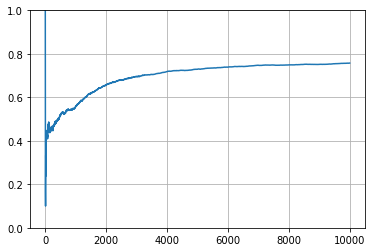

In [65]:
# 勝率の変化
wininig_Q = np.array(nn_q_learning.record) == WIN

plt.grid(True)
plt.ylim(0, 1)
plt.plot(np.cumsum(wininig_Q) / (np.arange(len(wininig_Q)) + 1))

### 遊ぶ

In [28]:
nn_q_learning = NNQLearningPlayer('Q太郎', q_function, memory, eps=0.)
game = TicTacToe(nn_q_learning, HumanPlayer('YAMAUCHI'))
game.main_loop(print_game=True)

actions: 
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8

Q太郎(X)'s turn.
   |   |   
-----------
   |   |   
-----------
   |   |  

YAMAUCHI(O)'s turn.
   |   |   
-----------
   |   |   
-----------
   | X |  



 4


Q太郎(X)'s turn.
   |   |   
-----------
   | O |   
-----------
   | X |  

YAMAUCHI(O)'s turn.
   |   |   
-----------
   | O |   
-----------
   | X | X



 6


Q太郎(X)'s turn.
   |   |   
-----------
   | O |   
-----------
 O | X | X

YAMAUCHI(O)'s turn.
   |   | X 
-----------
   | O |   
-----------
 O | X | X



 5


Q太郎(X)'s turn.
   |   | X 
-----------
   | O | O 
-----------
 O | X | X

YAMAUCHI(O)'s turn.
 X |   | X 
-----------
   | O | O 
-----------
 O | X | X



 3


 X |   | X 
-----------
 O | O | O 
-----------
 O | X | X

GAME is OVER!
WINNER: YAMAUCHI


...まだ弱い

### 自分自身との対局

In [66]:
memory0 = Memory(size=100)
memory1 = Memory(size=100)
nn_q_learning0 = NNQLearningPlayer('Q太郎', q_function, memory0, eps=0.05)
nn_q_learning1 = NNQLearningPlayer('Q次郎', q_function, memory1, eps=0.05)

In [67]:
for i in tqdm(range(3000)):

#     if i % 100 == 0:
#         print(i, end=', ')

    X = nn_q_learning0
    O = nn_q_learning1

    game = TicTacToe(X, O)
    game.main_loop(print_game=False)
    loss = train_q_function(q_function, memory0, optimizer)
    loss = train_q_function(q_function, memory1, optimizer)

#     if i % 100 == 0:
#         print(loss)

100%|██████████| 3000/3000 [01:23<00:00, 36.06it/s]


### もう一度遊ぶ

In [40]:
nn_q_learning = NNQLearningPlayer('Q太郎', q_function, memory, eps=0.)
game = TicTacToe(HumanPlayer('YAMAUCHI'), nn_q_learning)
game.main_loop(print_game=True)

actions: 
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8

YAMAUCHI(X)'s turn.
   |   |   
-----------
   |   |   
-----------
   |   |  



 4


Q太郎(O)'s turn.
   |   |   
-----------
   | X |   
-----------
   |   |  

YAMAUCHI(X)'s turn.
 O |   |   
-----------
   | X |   
-----------
   |   |  



 7


Q太郎(O)'s turn.
 O |   |   
-----------
   | X |   
-----------
   | X |  

YAMAUCHI(X)'s turn.
 O |   |   
-----------
   | X |   
-----------
 O | X |  



 1


 O | X |   
-----------
   | X |   
-----------
 O | X |  

GAME is OVER!
WINNER: YAMAUCHI
